# Using ES(1+1) 1/5 to find optimal hyperparameters for XOR model

Hyper parameters to optimiuze
- number of hidden neurons
- learning rate
- batch size
- loss function
- optimizer algorithm
- activation function

No contour plots here.

CJ Chung, Feb 2022, Sep 2025

License CC BY 4.0:
The CC BY 4.0 license allows anyone to share, adapt, and use the licensed work for any purpose, as long as they give appropriate credit to the original creator.

In [1]:
act_func = ('elu', 'sigmoid', 'tanh') # put highly selectable fn in the center

<img src=https://miro.medium.com/v2/resize:fit:720/format:webp/1*RD0lIYqB5L2LrI2VTIZqGw.png width=400>

In [2]:
# put highly selectble in the center
loss_func = ('mae', 'mse', 'binary_crossentropy', 'msle', 'hinge') # MLSE: Mean Squared Logarithmic Error
optimz = ('SGD', 'RMSprop', 'Adam')

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import optimizers
from keras.models import save_model, load_model
import matplotlib.pyplot as plt
import numpy as np

X  = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([[0],[1],[1],[0]])
Xt = np.array([[0.1,0], [0.2,0.19], [0,0.9], [0.8, 0.1], [0.9,0.2], [0.9,0.9]])
yt = np.array([[0],     [0],        [1],     [1],        [1],       [0]])

# 0: num_neurons, 1: lr, 2: bsize, 3: actfun, 4: lossfun, 5: optmzr

def XOR_eval(param):
  global model
  model = Sequential()
  model.add(Dense(int(param[0]), input_dim=2)) # Num hidden neurons
  model.add(Activation(act_func[ round(param[3]) ]))
  model.add(Dense(1))
  model.add(Activation(act_func[ round(param[3]) ]))
  if ( param[5] == 0 ):
    optmzr = optimizers.SGD(learning_rate=param[1]) # stochastic gradient decent
  elif ( param[5] == 1 ):
    optmzr = optimizers.RMSprop(learning_rate=param[1])
  elif ( param[5] == 2 ):
    optmzr = optimizers.Adam(learning_rate=param[1])
  #model.compile(loss='mean_squared_error', optimizer=optmzr, metrics=['binary_accuracy'])
  model.compile(loss=loss_func[ round(param[4]) ], optimizer=optmzr, metrics=['binary_accuracy'])
  # binary_accuracy: Calculates how often predictions match binary labels
  model.fit(X, y, batch_size=int(param[2]), epochs=350, verbose=0)
  (loss, acc) = model.evaluate(Xt, yt, verbose=0)

  return loss

In [4]:
# to test a set of parameters
# 0: num_neurons, 1: lr, 2: bsize, 3: actfun, 4: lossfun, 5: optmzr
pr = np.empty(6)
pr[0] = 3   # num hidden neuron
pr[1] = 1.5 # lr
pr[2] = 1   # batch size
pr[3] = 1   # ('elu', 'sigmoid', 'tanh')
pr[4] = 2   # ('mae', 'mse', 'binary_crossentropy', 'msle', 'hinge')
pr[5] = 1   # ('SGD', 'RMSprop', 'Adam')
print(XOR_eval(pr))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


0.5351656675338745


In [5]:
# Constants
MaxGen = 35
MaxTrial = 3
numVar = 6

In [6]:
#@title testing Python np basics
x1 = np.array([1,2,3,4])
y1 = np.array([2,3,4,5])
def func(xy):
  return xy[0]*xy[1]
func([x1,y1])

array([ 2,  6, 12, 20])

In [7]:
#@title test random generators, integer numbers between 1 and 9
np.random.seed(1)
#for _ in range(20):
  #print(round(np.random.uniform(1, 10)))

In [8]:
#@title test random generators, float numbers between 0.01 ~ 1.50
np.random.seed(1)
print(round(1.2345, 2))
#for _ in range(20):
  #print(round(np.random.uniform(0.01, 1.5), 2))

1.23


In [9]:
#@title test normal random generators
np.random.seed()
#for _ in range(20):
  #print(round(np.random.normal(0.0, 0.82)))

In [10]:
# num_neurons, lr, actfun, bsize, lossfun, optmzr
def print_HP_found(x, eval):
  print(f"#neurons={int(x[0])}, lr={x[1]:.3f}, bsize={int(x[2])}, actF={act_func[int(x[3])]},  lossF={loss_func[int(x[4])]}, optim={optimz[int(x[5])]}")
  print(f"Eval={eval}")

In [11]:
totgen = 0
foundCnt = 0  # acceptable solution found
objfunc = XOR_eval #
#np.random.seed(1) # makes the random numbers predictable to debug

# for 1/5 rule
stepSize_i = 0.82 # initial stepsize
stepSize_r = 0.82 # stepsize change ratio.
                  # 0.82 was used previously by Hans-Paul Schwefel, a PhD student of Rechenberg

In [12]:
print(f"[#neurons, lr, bsize, actfun, lossfun, optmzr]")

for trial in range(0, MaxTrial):
    best_p_val = 9999 # a large number
    xp = np.empty(numVar) # parent
    p_val = 0
    xo = np.empty(numVar) # offspring
    o_val = 0

    successCnt = 0;
    WindowSize = 10

    #X_trajectory = np.array([]) # for contour graph. Stored last trial's results
    #Y_trajectory = np.array([])

    print(f"************************** Trial # = {trial+1}")
    # https://machinelearningmastery.com/how-to-generate-random-numbers-in-python/
    #xp[0] = round(np.random.uniform(low0, high0)) # init number of neurons

    # initialize hyper parameters using tuples (initial_value, lower_bound, upper_bound)
    hparams = [
        (2, 1, 10),   # num hidden neuron, low_b, high_b
        (round(np.random.uniform(0.01, 1.5), 2), 0.01, 1.5), # lr
        (2, 1, 4),   # batch size
        (1, 0, 2),   # act fn: ('elu', 'sigmoid', 'tanh')
        (2, 0, 4),   # loss fn: ('mae', 'mse', 'binary_crossentropy', 'msle', 'hinge')
        (1, 0, 2)    # optimizers: ('SGD', 'RMSprop', 'Adam')
    ]

    # Assign initial values to parent
    for i in range(numVar):
        xp[i] = hparams[i][0]

    p_val = objfunc(xp)     # evaluate the parent
    #X_trajectory = np.append(X_trajectory, xp[0])
    #Y_trajectory = np.append(Y_trajectory, xp[1])

    stepSize = stepSize_i

    for g in range(1, MaxGen+1):
        # Test later if this step size can be place at the end of the loop part
        if (g % WindowSize) == 0: # update stepsize
            if successCnt > (WindowSize * 0.2):
                stepSize = stepSize / stepSize_r #increase
            elif successCnt < (WindowSize * 0.2):
                stepSize = stepSize * stepSize_r #decrease
            #else do not change stepSize
            #print(successCnt, stepSize)
            successCnt = 0

        # mutate each hyperparameter
        for i in range(numVar):
            xo[i] = xp[i] + round(np.random.normal(0.0, stepSize), 2 if i == 1 else 0) # Apply rounding to 2 decimal places only for learning rate (index 1)
            # to correct if any variation goes out of acceptable range
            xo[i] = np.clip(xo[i], hparams[i][1], hparams[i][2]) # hparams[i][1]: lower_bound

        o_val = objfunc(xo)  # evaluate offspring

        # select
        if o_val < p_val:
            #xp = xo # No! must maintain two separate spaces
            xp = xo.copy()
            p_val = o_val
            successCnt += 1;
            #print(xp, p_val, successCnt, stepSize)
            #X_trajectory = np.append(X_trajectory, xp[0])
            #Y_trajectory = np.append(Y_trajectory, xp[1])

        if p_val < 0.01: # we assume minima is zero.
            print(f"Acceptable solution found after {g} iterations:")
            #print(f"{xp}, {p_val:.5f}")
            print_HP_found(xp, p_val)
            if p_val < best_p_val:
                best_p_val = p_val
                #save_model(model, 'best' + str(p_val) + '.keras')
                save_model(model, 'bestXOR.keras')
            totgen += g
            foundCnt += 1
            break # cannot use while since it may not find acceptable minia
      # end of generation
    # end of Trial
    #plot_contour(X_trajectory, Y_trajectory)
    #plot_contour()
print(f"System Success = {foundCnt/MaxTrial*100}%")
totgen += (MaxTrial-foundCnt)*MaxGen
print(f"Avgerage # of generations used = {(totgen/MaxTrial):,.0f}")

[#neurons, lr, bsize, actfun, lossfun, optmzr]
************************** Trial # = 1
Acceptable solution found after 19 iterations:
#neurons=4, lr=1.500, bsize=2, actF=sigmoid,  lossF=mse, optim=RMSprop
Eval=2.0398085780470865e-06
************************** Trial # = 2
************************** Trial # = 3
Acceptable solution found after 4 iterations:
#neurons=2, lr=0.680, bsize=2, actF=sigmoid,  lossF=binary_crossentropy, optim=Adam
Eval=0.0019610391464084387
System Success = 66.66666666666666%
Avgerage # of generations used = 19


In [13]:
m1=load_model('bestXOR.keras')
m1.summary()

Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_122 (Dense)               │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_122 (Activation)     │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_123 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29 (120.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20 (84.00 B)

xpoints: [0. 0. 1. 1.]
ypoints: [0. 1. 0. 1.]


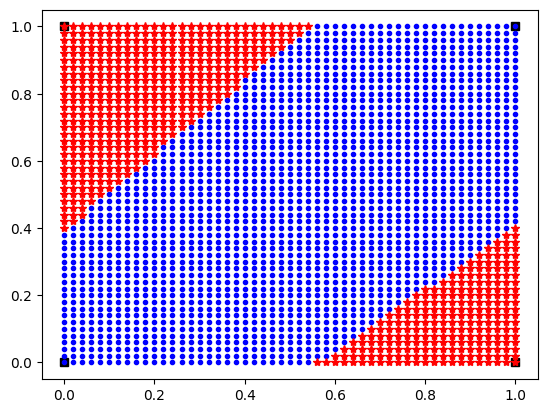

Fired (red) % = 26.297577854671278


In [14]:
import matplotlib.pyplot as plt
# Python practice with numpy arrays to display 4 inputs
xpoint = np.array([])
ypoint = np.array([])
for i in X:
    xpoint = np.append(xpoint, i[0])
    ypoint = np.append(ypoint, i[1])

print ("xpoints:", xpoint)
print ("ypoints:", ypoint)

#--------- to display every mesh grid points by learned NN -----
#xp = np.array([])
#yp = np.array([])

xp_zero = np.array([])
yp_zero = np.array([])
xp_one = np.array([])
yp_one = np.array([])
numZero = 0
numOne = 0

for x in np.arange(0.0, 1.02, 0.02): # cannot use range since start and stop must be int
  for y in np.arange(0.0, 1.02, 0.02):
    #xp = np.append(xp,x)
    #yp = np.append(yp,y)
    xy = np.array([[x,y]])
    if m1.predict(xy, verbose=0) > 0.5:
      xp_one = np.append(xp_one,x)
      yp_one = np.append(yp_one,y)
      numOne += 1
    else:
      xp_zero = np.append(xp_zero, x)
      yp_zero = np.append(yp_zero, y)
      numZero += 1

#print ("xp:", xp)
#print ("yp:", yp)

# -------- PLOT the graph -----
plt.plot(xpoint, ypoint, 'ks') # to plot 4 points in x. k is for black
plt.plot(xp_zero, yp_zero, 'b.') # to plot all non-fired points
plt.plot(xp_one, yp_one, 'r*') # to plot all fired points
plt.show() # Show the figure
print (f"Fired (red) % = {numOne/(numZero+numOne)*100}")

## Future work
- Add num epoch as a Hyper Param
- Introduce "Crossover" using ES(n+m)1/5. ES(1+1)1/5 is using only mutations
- More sampe data as such as

```
    0.0  0.0   0
    0.1  0.1   0
    0.0  1.0   1
    0.1  0.9   1
    1.0  0.0   1
    0.9  0.1   1
    1.0  1.0   0
    0.9  0.9   0
```

- More complex problems such as 3 classes

<pre>
    0.0  0.0   0
    0.0  1.0   1
    1.0  0.0   1
    1.0  1.0   0
    0.5  0.5   2
    0.6  0.6   2
</pre>

- XOR with 3 inputs
<img src="https://media.geeksforgeeks.org/wp-content/uploads/20240809064050/3-Input-XOR-Gate-1024.png" width="300">

- Display very bad set of hparam too.
- find hparams that are not dependent on other hparams
- Find good range for each hparam
- Find rules usig decicion trees ?
- ...